# **Import Dataset and Libraries**

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from folium.plugins import HeatMap
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Change File Location
df = pd.read_csv("C:/Users/aidan_000/Desktop/UNCC/ML Project/Data Manipulation/df8.csv", low_memory=False)

# Create a new DataFrame with selected coordinates and crime-related columns
coordinates = pd.DataFrame(df[['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP']].values, columns= ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP'])
df.head()

,ZIP,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,Year,Month,Day,DayOfWeek,CMPD_PATROL_DIVISION,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,...,PctHH_Poverty,PctHome_Ownership,HighSchool,NonWhite,F65_,Poverty,Home_Ownership,Score,VulnerableBinary,Violent-Crime
0,28215,35.258195,-80.726229,2023,12,4,0,1,1,1,...,0.07,0.75,1,1,0,0,0,2,0,0
1,28213,35.283274,-80.762293,2023,12,4,0,2,1,2,...,0.16,0.76,1,1,0,1,0,3,0,0
2,28210,35.153683,-80.839845,2023,12,4,0,5,3,4,...,0.11,0.53,0,0,1,0,1,2,0,0
3,28227,35.221991,-80.814908,2023,12,4,0,6,1,4,...,0.04,0.77,0,0,0,0,0,0,0,0
4,28216,35.362708,-80.854438,2023,12,4,0,7,0,4,...,0.05,0.40,0,1,0,0,1,2,0,1


# **Pre-processing**

In [25]:
# validation_set = df[df['Year'] == 2023]
# training_set = df[df['Year'] != 2023]

# # Extract features and labels for the test set (2023)
# y_test = training_set['CRIME_TYPE_MAP'].values
# x_test = training_set.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime']).values

# # Extract features and labels for the training set (all years except 2023)
# y_train = validation_set['CRIME_TYPE_MAP'].values
# x_train = validation_set.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime']).values

# # Standardize the features if needed
# X_train = StandardScaler().fit_transform(x_train)
# X_test = StandardScaler().fit_transform(x_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [26]:
# Extract Ground Truths from the original DataFrame
Y = df[['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP']]
y = df['CRIME_TYPE_MAP'].values

# Drop unnecessary columns from the feature set
df = df.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime'])

# Convert the feature set and target variables into numpy array
x = df.values

# Split the dataset into training and testing sets and standardize
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# **Model Declaration and Instantiation**

In [27]:
# Create DataLoader for training and testing set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the spatiotemporal model
class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()

        # Convolutional layer for feature extraction
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        # Long Short-Term Memory (LSTM) layer for capturing temporal patterns
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        # Fully connected layer for classification
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        # Add a channel dimension for Conv1d
        x = x.unsqueeze(2) 
        x = F.relu(self.conv1d(x))
        # LSTM expects input in (batch, seq_len, features) format
        x, _ = self.lstm(x.permute(0, 2, 1)) 
        # Take the output of the last time step
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# Instantiate the model for multi-class classification (8 classes)
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))  # Number of classes
model = SpatiotemporalModel(input_size, output_size).to(device)

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
start_time = time.time()
for epoch in range(epochs):
    
    # Set Model to training mode
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move both inputs and labels to the device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    all_predictions = []
    
    # Set Model to evaluation mode
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
 
    val_accuracy = correct / total
    


    # Print epoch information
    if epoch % 5 == 0:
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Time: 15.57s, Validation Accuracy: 0.5304
Epoch 6/50, Time: 16.91s, Validation Accuracy: 0.5447
Epoch 11/50, Time: 16.03s, Validation Accuracy: 0.5476
Epoch 16/50, Time: 15.54s, Validation Accuracy: 0.5504
Epoch 21/50, Time: 15.56s, Validation Accuracy: 0.5511
Epoch 26/50, Time: 15.66s, Validation Accuracy: 0.5524
Epoch 31/50, Time: 16.10s, Validation Accuracy: 0.5523
Epoch 36/50, Time: 15.45s, Validation Accuracy: 0.5509
Epoch 41/50, Time: 15.16s, Validation Accuracy: 0.5509
Epoch 46/50, Time: 15.75s, Validation Accuracy: 0.5512


In [32]:
# Create a DataFrame for predictions with relevant columns
prediction_df = pd.DataFrame({
    'ZIP': x_test[:, 0],
    'LATITUDE_PUBLIC': x_test[:, 1],
    'LONGITUDE_PUBLIC': x_test[:, 2],
    'CRIME_TYPE_MAP': all_predictions
})

# Define a mapping dictionary for numerical class labels to readable crime types
mapping_dict = {
    0: 'Assault',
    1: 'Thefts',
    2: 'Vehicle Thefts', 
    3: 'Property Offenses',
    4: 'Sexual Offenses',
    5: 'Money Offenses',
    6: 'Drug Offenses',
    7: 'Falsification'
}

# Map numerical predictions to human-readable crime types and create a new column
prediction_df['PREDICTED_CRIME_TYPE'] = prediction_df['CRIME_TYPE_MAP'].map(mapping_dict)

# **Data Visualization**

Confusion Matrix Plot

              precision    recall  f1-score   support

           0       0.46      0.39      0.42     10590
           1       0.61      0.66      0.64     19409
           2       0.55      0.84      0.66     13605
           3       0.28      0.01      0.03      4924
           4       0.70      0.17      0.27       749
           5       0.22      0.01      0.02      1700
           6       0.44      0.41      0.42      2868
           7       0.62      0.26      0.37       892

    accuracy                           0.55     54737
   macro avg       0.48      0.35      0.35     54737
weighted avg       0.52      0.55      0.51     54737



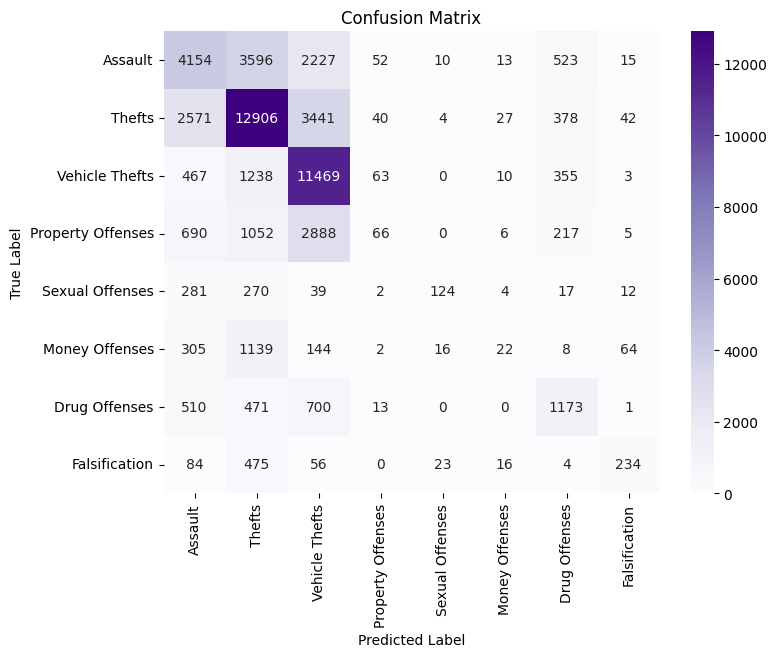

In [33]:
# List of crime types corresponding to class labels
crime_types = ['Assault', 'Thefts', 'Vehicle Thefts', 'Property Offenses', 'Sexual Offenses', 'Money Offenses', 'Drug Offenses', 'Falsification']

# Convert PyTorch tensors to NumPy arrays for evaluation
y_test_np = y_test_tensor.cpu().numpy()
all_predictions_np = np.array(all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, all_predictions_np)

# Display classification report with zero division handling
report = classification_report(y_test_np, all_predictions_np, zero_division=1)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=crime_types, yticklabels=crime_types)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Crime Prediction Map

In [36]:
# Calculate the minimum and maximum latitude and longitude values from the coordinates DataFrame
minLatitude = coordinates.iloc[:, 1].min()
maxLatitude = coordinates.iloc[:, 1].max()
minLongitude = coordinates.iloc[:, 2].min()
maxLongitude = coordinates.iloc[:, 2].max()

# Calculate the center latitude and longitude for map visualization
centerLatitude = (minLatitude + maxLatitude) / 2
centerLongitude = (minLongitude + maxLongitude) / 2

# Specify the crime type for map visualization
CrimeType = 'Thefts'

# Create a folium map centered around the calculated latitude and longitude
PredictionMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=11)

# Filter the prediction DataFrame for the specified crime type
PredictionPoints = prediction_df[prediction_df['PREDICTED_CRIME_TYPE'] == CrimeType][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']]

# Add a heatmap layer to the map based on the filtered points
HeatMap(PredictionPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'blue', 0.65: 'lime', 1: 'yellow'}).add_to(PredictionMap)

# Display the map
PredictionMap

# Save the map as an HTML file (optional)
#PredictionMap.save('PredictionMap_MultiClassModel.html')

In [37]:
# Create a folium map for actual crime data centered around the calculated latitude and longitude
ActualMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=11)

# Filter the coordinates DataFrame for the specified crime type
ActualPoints = coordinates[coordinates['CRIME_TYPE'] == CrimeType][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']]

# Add a heatmap layer to the map based on the filtered actual crime points
HeatMap(ActualPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'blue', 0.65: 'lime', 1: 'yellow'}).add_to(ActualMap)

# Display the map
ActualMap

# Save the map as an HTML file (optional)
#ActualMap.save('ActualHeatmap_MultiClassModel.html')